In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: 
# https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames
          #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) 
# that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, 
# but they won't be saved outside of the current session

# import Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import cv2, os, gc, glob
from tqdm import tqdm

from tensorflow.keras import layers, models

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical, np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# ****Explorer****

In [30]:
os.listdir('/kaggle/input')

['covid19-radiography-database']

In [31]:
os.listdir('/kaggle/input/covid19-radiography-database')

['COVID-19 Radiography Database']

In [32]:
os.listdir('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database')

['Viral Pneumonia.matadata.xlsx',
 'NORMAL.metadata.xlsx',
 'COVID-19',
 'COVID-19.metadata.xlsx',
 'README.md.txt',
 'NORMAL',
 'Viral Pneumonia']

In [33]:
# Image paths

imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [34]:
# Data - Label

Data = []
Target = []
resize = 150

cat = {'Viral Pneumonia': 'Pneumonia', 'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}

for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(cat[label])

100%|██████████| 2905/2905 [01:04<00:00, 45.32it/s]


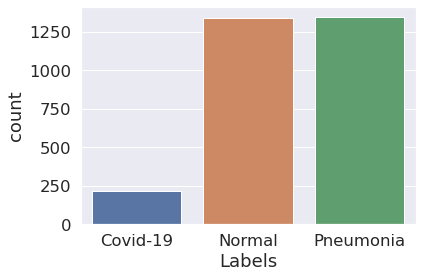

Covid-19: 219
Normal: 1341
Pneumonia:  1345


In [35]:
# Count by Label

df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print('Covid-19:',Target.count('Covid-19'))
print('Normal:',Target.count('Normal'))
print('Pneumonia: ',Target.count('Pneumonia'))

In [36]:
# Images shape

size = []
for file in imagePaths: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(1024, 1024)       2554
(1024, 1024, 3)     351
dtype: int64

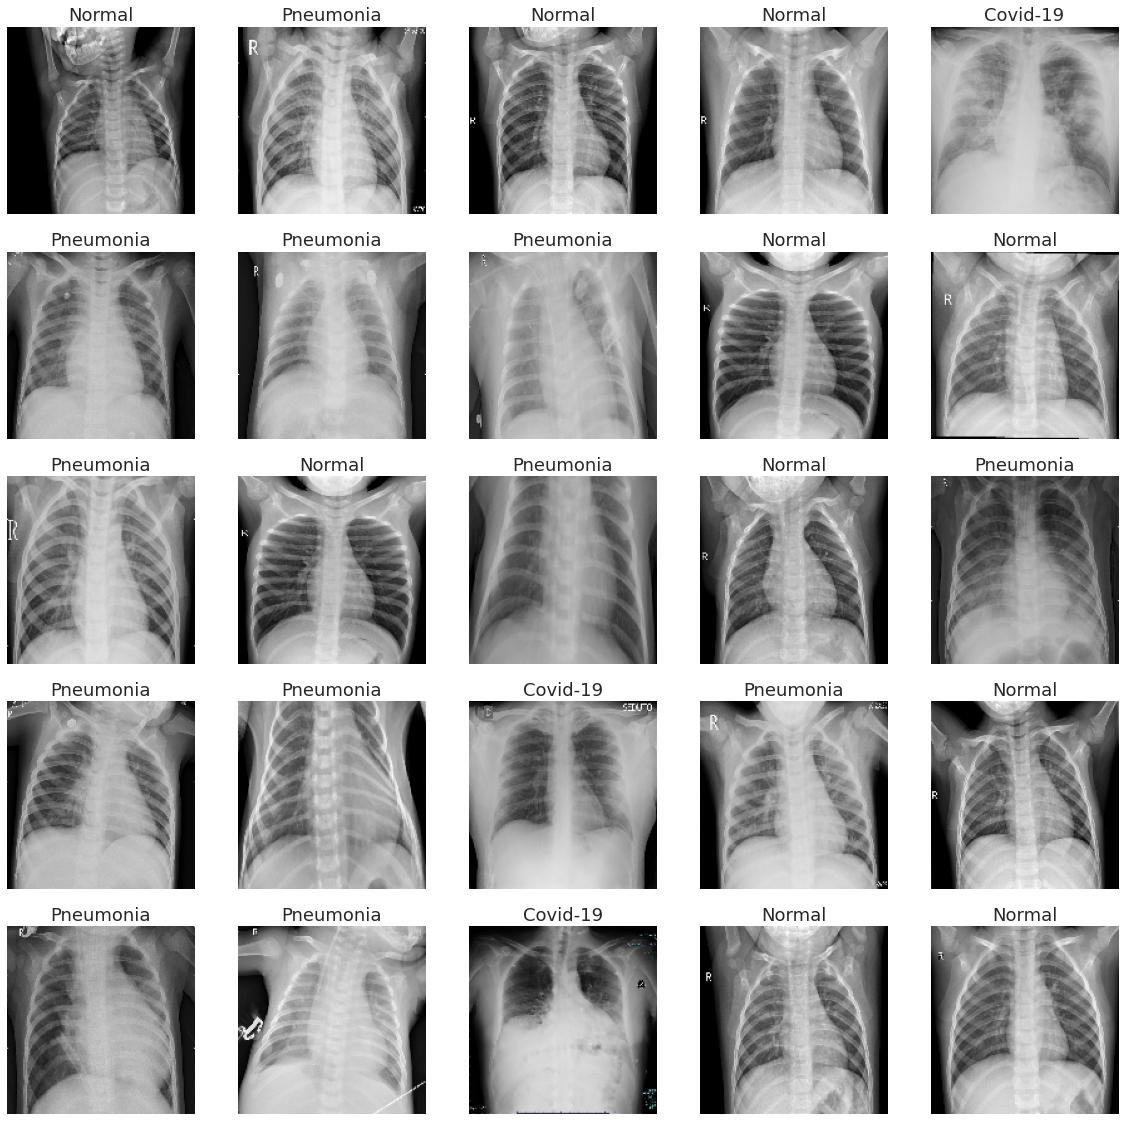

In [52]:
# Show Images

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

# Prepare Data

In [38]:
# encode labels as integers

le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Normal' 'Pneumonia']
[1. 0. 0.]


In [39]:
# split Data

(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=42)

trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2324, 150, 150, 3)
(581, 150, 150, 3)
(2324, 3)
(581, 3)


In [40]:
trainX[0]

array([[[0.75294118, 0.75294118, 0.75294118],
        [0.71372549, 0.71372549, 0.71372549],
        [0.61568627, 0.61568627, 0.61568627],
        ...,
        [0.07843137, 0.07843137, 0.07843137],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        [0.03921569, 0.03921569, 0.03921569]],

       [[0.63137255, 0.63137255, 0.63137255],
        [0.74117647, 0.74117647, 0.74117647],
        [0.61568627, 0.61568627, 0.61568627],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.01176471, 0.01176471, 0.01176471],
        [0.02745098, 0.02745098, 0.02745098]],

       [[0.59215686, 0.59215686, 0.59215686],
        [0.67058824, 0.67058824, 0.67058824],
        [0.69803922, 0.69803922, 0.69803922],
        ...,
        [0.23137255, 0.23137255, 0.23137255],
        [0.05490196, 0.05490196, 0.05490196],
        [0.02745098, 0.02745098, 0.02745098]],

       ...,

       [[0.15294118, 0.15294118, 0.15294118],
        [0.01176471, 0.01176471, 0.01176471],
        [0.        , 0

# Model

In [41]:
s = 150 # size

In [42]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(s,s,3), kernel_initializer='he_normal',))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))

model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax"))

In [43]:
# Compile 

model.compile(optimizer = keras.optimizers.Adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])

In [44]:
# Model Details

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 33, 33, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 33, 128)      

In [45]:
epochs = 30

ThisModel = model.fit(trainX, trainY, epochs=epochs, batch_size=40, verbose=1)

Epoch 1/30
59/59 [==============================] - 57s 961ms/step - loss: 1.2240 - accuracy: 0.7397
Epoch 2/30
59/59 [==============================] - 56s 951ms/step - loss: 0.2805 - accuracy: 0.9028
Epoch 3/30
59/59 [==============================] - 56s 947ms/step - loss: 0.1861 - accuracy: 0.9324
Epoch 4/30
59/59 [==============================] - 56s 951ms/step - loss: 0.1558 - accuracy: 0.9479
Epoch 5/30
59/59 [==============================] - 59s 995ms/step - loss: 0.1326 - accuracy: 0.9518
Epoch 6/30
59/59 [==============================] - 54s 917ms/step - loss: 0.0841 - accuracy: 0.9716
Epoch 7/30
59/59 [==============================] - 54s 922ms/step - loss: 0.0821 - accuracy: 0.9677
Epoch 8/30
59/59 [==============================] - 54s 918ms/step - loss: 0.0773 - accuracy: 0.9725
Epoch 9/30
59/59 [==============================] - 55s 928ms/step - loss: 0.0451 - accuracy: 0.9824
Epoch 10/30
59/59 [==============================] - 55s 933ms/step - loss: 0.0577 - accura

# Results

In [46]:
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

Test Loss is 0.20356051623821259
Test Accuracy is 0.9655765891075134


In [47]:
class_names = ['COVID-19','Normal','Viral Pneumonia']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

COVID-19


In [48]:
# classification report on train
batch_size=40

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.99432   1.00000   0.99715       175
      Normal    0.99444   1.00000   0.99721      1073
   Pneumonia    1.00000   0.99349   0.99674      1076

    accuracy                        0.99699      2324
   macro avg    0.99625   0.99783   0.99703      2324
weighted avg    0.99700   0.99699   0.99699      2324



In [49]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.91489   0.97727   0.94505        44
      Normal    0.94662   0.99254   0.96903       268
   Pneumonia    0.99605   0.93680   0.96552       269

    accuracy                        0.96558       581
   macro avg    0.95252   0.96887   0.95987       581
weighted avg    0.96710   0.96558   0.96559       581



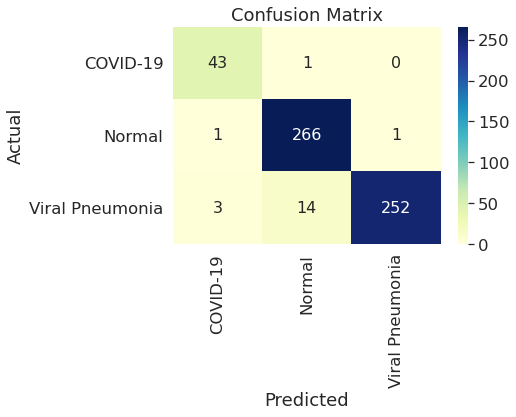

In [50]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x, index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [51]:
model.save('CNN_Covid19_Xray_V1.h5') 